#                              PAAD RNA-Seq Analysis

### Imports

In [1]:
import pandas as pd
import numpy as np
import scipy

from cmapPy.pandasGEXpress.GCToo import GCToo
from cmapPy.pandasGEXpress.parse import parse

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt


### Load dataset 

In [2]:
gct = parse('data/PAAD.gct')
data = gct.data_df
meta_col = gct.col_metadata_df
meta_row = gct.row_metadata_df

# Explore Dataset

#### Dataset dimensions

In [3]:
data.shape, meta_col.shape, meta_row.shape

((18465, 183), (183, 124), (18465, 0))

#### Types of tissues

In [4]:
# unique columns : sample types
set([col.split('-')[1] for col in data.columns])

{'Metastatic', 'Primary solid Tumor', 'Solid Tissue Normal'}

#### Pathological parameters in dataset

In [5]:
cols = [print(col) for col in meta_col.columns]

participant_id
sample_type
mRNAseq_cluster
bcr_patient_barcode
bcr_patient_uuid
vital_status
days_to_death
days_to_last_followup
additional_studies
adenocarcinoma_invasion
age_at_initial_pathologic_diagnosis
alcohol_history_documented
alcoholic_exposure_category
amount_of_alcohol_consumption_per_day
anatomic_neoplasm_subdivision
anatomic_neoplasm_subdivision_other
b_symptoms
bcr
bcr_aliquot_uuid
bcr_canonical_reason-2
bcr_canonical_reason-3
bcr_canonical_reason
bcr_followup_barcode
bcr_followup_uuid
bcr_patient_canonical_status
clinical_m
clinical_n
clinical_stage
clinical_t
course_number
day_of_dcc_upload
day_of_form_completion
days_to_birth
days_to_diabetes_onset
days_to_index
days_to_initial_pathologic_diagnosis
days_to_pancreatitis_onset
days_to_psa
disease_code
drugs
ethnicity
extranodal_involvement
family_history_of_cancer
file_uuid
follow_ups
followup_case_report_form_submission_reason
followup_treatment_success
frequency_of_alcohol_consumption
gender
gleason_score
histologic_gr

### Histology 

In [6]:
for hist, meta in meta_col.groupby('histological_type'):
    print(hist, ':')
    for hist_other, other_meta in meta.groupby('histological_type_other'):
        print('\t', hist_other)

pancreas-adenocarcinoma ductal type :
pancreas-adenocarcinoma-other subtype :
	 82463 neuroendocrine carcinoma nos
	 adenocarcinoma, nos
	 adenocarcinoma- nos
	 ductal and micropapillary
	 intraductal tubulopapillary neoplasm
	 invasive adenocarcinoma
	 invasive, well-differentiated
	 moderately differentiated ductal adenocarcinoma 60% + neuroendocrine 40%
	 neuroendocrine
	 neuroendocrine carcinoma
	 neuroendocrine carcinoma nos
	 not specified
	 poorly differentiated adenocarcinoma
	 poorly differentiated pancreatic adenocarcinoma
pancreas-colloid (mucinous non-cystic) carcinoma :
pancreas-undifferentiated carcinoma :


### Out of all Pancreatic histology, how many are neuroendocrine?

In [99]:
# neuroendocrine ids 
nids = []
print('Neuroendocrine Histologies: ')
for hist_other, other_meta in meta_col.groupby('histological_type_other'):
    if 'neuroendocrine' in hist_other and not 'moderately' in hist_other:
        print('\t', hist_other)
        for id_ in other_meta.index:
            nids.append(id_)
print('\nTotal # Neuroendocrine :', len(nids))


Neuroendocrine Histologies: 
	 82463 neuroendocrine carcinoma nos
	 neuroendocrine
	 neuroendocrine carcinoma
	 neuroendocrine carcinoma nos

Total # Neuroendocrine : 8


##### Create ground truth binary labels ((adenocarcinoma vs neuroendocrine))

In [8]:
Y = data.columns.tolist()
for i, id_ in enumerate(Y):
    Y[i] = 0
    if id_ in nids:
       Y[i] = 1
Y = np.array(Y)

# Preprocessing

### Investigate Missing Data

#### Missing gene values per sample

count     183.000000
mean      737.453552
std       264.169332
min       294.000000
25%       564.000000
50%       697.000000
75%       837.500000
max      1944.000000
dtype: float64


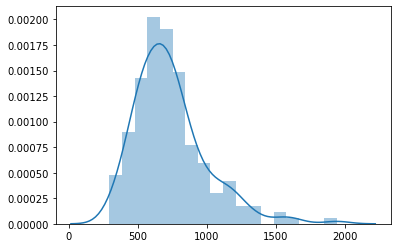

In [9]:
missing = data.shape[0] -  data.count()
print(missing.describe())
sns.distplot(missing)

***Transpose data***

In [10]:
data = data.T

#### Missing samples for each gene

count    18465.000000
mean         7.308638
std         22.106567
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        128.000000
dtype: float64


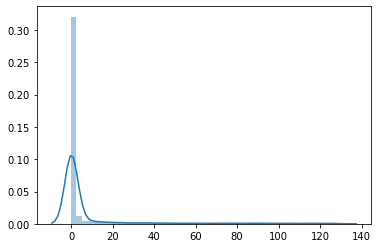

In [11]:
missing = data.shape[0] -  data.count()
print(missing.describe())
sns.distplot(missing)

### As there are a large number of missing values in the dataset, KNN based weighted Imputing is used to fill-in the missing values : [_ref_](https://www.researchgate.net/publication/316117685_Missing_value_imputation_for_gene_expression_data_by_tailored_nearest_neighbors)

#### Using KNN distance weighted imputer for missing values:
**_it has been found k = [[5,10]](http://www.web.stanford.edu/~hastie/Papers/missing.pdf) is a good choice for gene experssion data._**

In [12]:
X = data.to_numpy()
X = KNNImputer(n_neighbors=5, weights='distance').fit_transform(X)

# Using PCA for dimensionality reduction and visualization 

In [62]:
pca = PCA(n_components=20, random_state=42)
componenets = pd.DataFrame(pca.fit_transform(X))

### Plotting variance ratios for consequtive principal components suggests only first 3 pcas are usable

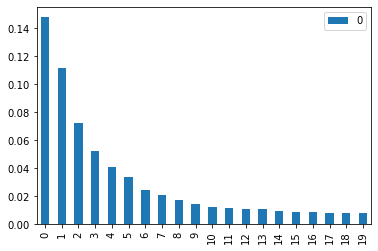

In [63]:
pd.DataFrame(pca.explained_variance_ratio_).plot.bar()

# K Means Clustering upon PCA for classification

### Determine the best k parameter for clustering 

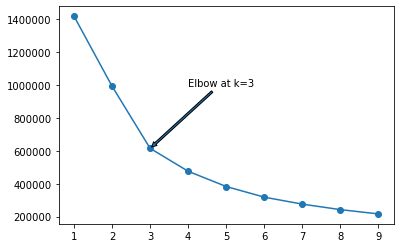

In [64]:
inertias = []
for k in range(1,10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(componenets.iloc[:,:3])
    inertias.append(kmeans.inertia_)
plt.plot(range(1,10), inertias, '-o')
# elbows at k=3
plt.annotate('Elbow at k=3', xy=(3, inertias[3-1]), xytext=(4, inertias[1]), arrowprops=dict(arrowstyle='simple'))
plt.show()
components = componenets.iloc[:,:3]
componenets.columns = list(map(str, componenets.columns))

### Applying K-Means using k = 3 clusters on first 3 principal components

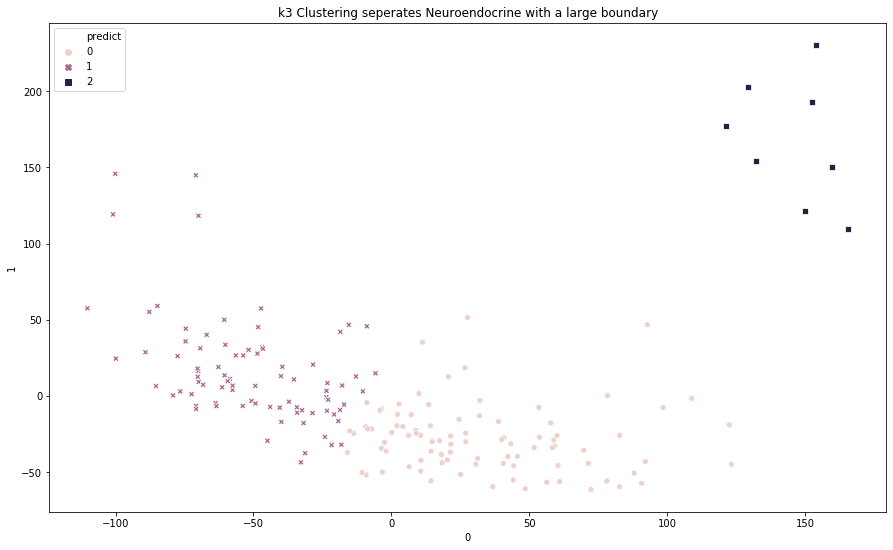

In [65]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(componenets.iloc[:,:3])
componenets['predict'] = kmeans.predict(componenets.iloc[:,:3])
plt.figure(figsize=(15,9))
plt.title('k3 Clustering seperates Neuroendocrine with a large boundary')
sns.scatterplot(x='0', y='1', hue='predict', style='predict', data=componenets)

# Evaluating Clustering  

***Storing ground truth (adenocarcinoma , neuroendocrine) : (0 , 1)   labels for evaluation***

In [66]:
componenets['labels'] = Y

#### Ternary KMeans predicted class = 2 corresponds to ground truth class = 1

In [67]:
# missclassifications 
componenets['histological_type'] = meta_col['histological_type'].values
componenets['histological_type_other'] = meta_col['histological_type_other'].values
componenets[['labels', 'predict', 'histological_type', 'histological_type_other']][componenets.predict == 2]

,labels,predict,histological_type,histological_type_other
22,1,2,pancreas-adenocarcinoma-other subtype,neuroendocrine
29,1,2,pancreas-adenocarcinoma-other subtype,neuroendocrine carcinoma nos
30,1,2,pancreas-adenocarcinoma-other subtype,neuroendocrine carcinoma nos
31,1,2,pancreas-adenocarcinoma-other subtype,neuroendocrine carcinoma nos
32,1,2,pancreas-adenocarcinoma-other subtype,neuroendocrine carcinoma nos
33,1,2,pancreas-adenocarcinoma-other subtype,neuroendocrine carcinoma nos
34,1,2,pancreas-adenocarcinoma-other subtype,82463 neuroendocrine carcinoma nos
36,1,2,pancreas-adenocarcinoma-other subtype,neuroendocrine carcinoma


#### As can be seen in the above dataframe's 'histological_type_other'; there are no missclassifications

### Plotting ground truth labels on PCA0 and PCA1 to visually confirm clustering accuracy

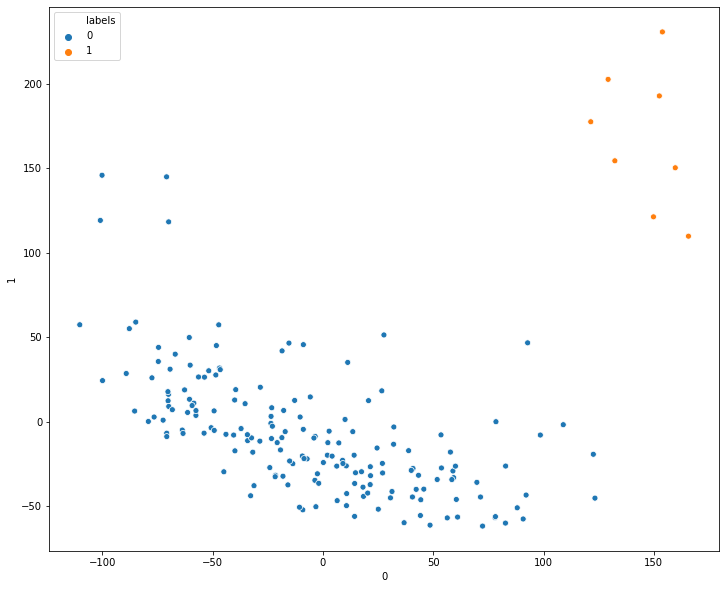

In [59]:
plt.figure(figsize=(12,10))
sns.scatterplot(x='0', y='1', hue='labels', data=componenets)

# Linear Classification 

### If Dimensionality reduction shows perfect seperability, will a simpler linear model fit on higher dimensions?

## Logistic Regression 

**Create Training and Testing Dataset Split**

In [68]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print(y_test)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


***Data is highly unbalanced; Testing split should contain enough target labels***

In [71]:
print('# of neoendocrine samples in test data :', y_test.sum())

# of neoendocrine samples in test data : 3


### Logistic regression based on L2 regularization

In [74]:
lr = LogisticRegression(penalty='l2')
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Following graph shows the distance of the datapoints from the decision hyperplane

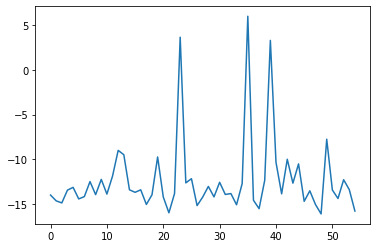

In [75]:
sns.lineplot(data=lr.decision_function(x_test))

#### As expected, perfect accuracy

In [76]:
print(lr.score(x_test, y_test))

1.0


#### There is inherently high seperabiltiy, but the learned weights are very dense

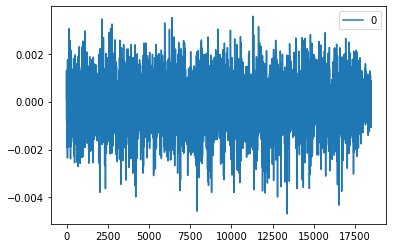

In [77]:
sns.lineplot(data=list(lr.coef_))

## Logistic Regression with L1 regularization

### L1 regularization heavily penalises weights to absolute zero for features with less predictive capability

In [81]:
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(x_train, y_train)
lr.score(x_test, y_test)

1.0

### Graph now shows the prominent features (Genes) that lead to this seperability between adenocarcinoma tumors and Neuroendocrine tumors

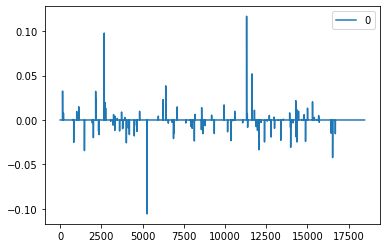

In [80]:
sns.lineplot(data=list(lr.coef_))

# Let's now remove Neuroendocrine tumors from the dataset

In [83]:
delete = componenets[['labels', 'predict', 'histological_type', 'histological_type_other']][componenets.predict == 1].index
data2 = data.drop(index=[data.index[i] for i in delete])
meta_col2 = meta_col.drop(index=[data.index[i] for i in delete])
data2.shape, meta_col2.shape

((100, 18465), (100, 124))

### Load Type 1 IFNs Geneset

In [84]:
# Load IFNS 
ifns = []
with open('data/type1_IFN.txt', 'r') as f:
    ifns = f.read().split('\n')
print('ifns :', len(ifns))
check = True
for ifn in ifns:
    check = check and ifn in data.columns
print('all present :', check)


ifns : 25
all present : True


## Box plot visualization shows the read spread of the 25 genes

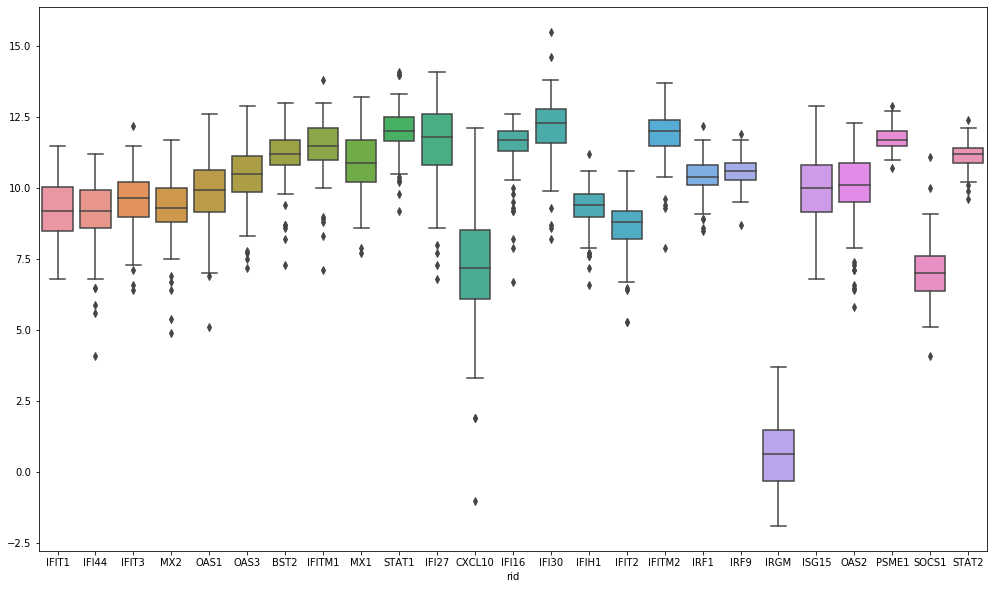

In [89]:
plt.figure(figsize=(17,10))
sns.boxplot(data=data2[ifns])


# GSVA Analysis for the Type 1 IFN Geneset 

### Python GSVA R-Package driver code; invokes gsva() in R runtime; fetches gsva pathways and scores output back to python runtime

In [92]:
import argparse, sys, os
import pandas as pd 
# from tempfile import mkdtemp, gettempdir
from subprocess import Popen, PIPE
import subprocess

# R GSVA function call params:
method='gsva'
kcdf='Gaussian'
abs_ranking=False
min_sz=1
max_sz=None
parallel_sz=0
parallel_type="SOCK"
mx_diff_options=[True, False] # two gsva calculations as on Hänzelmann, S., Castelo, R. & Guinney, J. GSVA
tau=None
ssgsea_norm=True
verbose=False
tempdir= None

df = data2.T
genset = pd.DataFrame(data={'name': ['type1ifn' for i in range(len(ifns))], 'member': ifns})

try:
    os.mkdir('temp')
except FileExistsError:
    pass
df.to_csv('temp/expr.csv')

members = genset['member'].unique()
genset = genset.groupby(['name']).apply(lambda x: "\t".join(sorted(list(x['member'])))).reset_index().rename(columns={0:'members'})
# Write our gene sets
with open('temp/gs.gmt','w') as f:
    for row in genset.itertuples():
        name = row.name
        description = 'description'
        fields = row.members
        f.write(name+"\t"+description+"\t"+fields+"\n")
cur = os.path.dirname(os.path.realpath('__file__'))
temp = os.path.join(os.path.dirname(os.path.realpath('__file__')), 'temp')
rscript = os.path.join(cur, 'gsva.r')
for mx_diff in mx_diff_options:
    cmd = ["Rscript", rscript]
    cmd += [str(x) for x in [method,kcdf,abs_ranking,min_sz,max_sz,parallel_sz,parallel_type,mx_diff,tau,ssgsea_norm,verbose,temp]]
    print('Rscript command to execute : ')
    print(cmd)
    result = subprocess.run(cmd, stdout=subprocess.PIPE, shell=True)
    print(result.stdout.decode('utf-8'))
    try:
        os.remove(f'temp/gsva_scores_mx_diff_{"t" if mx_diff else "f"}.csv')
    except FileNotFoundError:
        pass
    finally:
        os.rename('temp/gsva_scores.csv', f'temp/gsva_scores_mx_diff_{"t" if mx_diff else "f"}.csv')

Rscript command to execute : 
['Rscript', 'c:\\Users\\letha\\Projects\\wip\\PAADGeneExpression\\gsva.r', 'gsva', 'Gaussian', 'False', '1', 'None', '0', 'SOCK', 'True', 'None', 'True', 'False', 'c:\\Users\\letha\\Projects\\wip\\PAADGeneExpression\\temp']
[1] "c:\\Users\\letha\\Projects\\wip\\PAADGeneExpression\\temp/gsva_scores.csv"

Rscript command to execute : 
['Rscript', 'c:\\Users\\letha\\Projects\\wip\\PAADGeneExpression\\gsva.r', 'gsva', 'Gaussian', 'False', '1', 'None', '0', 'SOCK', 'False', 'None', 'True', 'False', 'c:\\Users\\letha\\Projects\\wip\\PAADGeneExpression\\temp']
[1] "c:\\Users\\letha\\Projects\\wip\\PAADGeneExpression\\temp/gsva_scores.csv"



## GSVA Scores for the presence of IFN Geneset signature in pancreatic adenocarcinoma tumors

In [94]:
gsva_scores = pd.read_csv('temp/gsva_scores_mx_diff_t.csv').iloc[:,1:]
gsva_scores = gsva_scores.append(pd.read_csv('temp/gsva_scores_mx_diff_f.csv').iloc[:,1:])
gsva_scores.index = ['mx_diff_true', 'mx_diff_false']
gsva_scores

,aab4-Primary solid Tumor,aab9-Primary solid Tumor,aabf-Primary solid Tumor,aabk-Primary solid Tumor,aabo-Primary solid Tumor,aabp-Primary solid Tumor,aabr-Primary solid Tumor,aabt-Primary solid Tumor,aabv-Primary solid Tumor,aaqi-Primary solid Tumor,...,a774-Primary solid Tumor,a77j-Primary solid Tumor,aaug-Primary solid Tumor,aauh-Primary solid Tumor,aaui-Primary solid Tumor,a8t3-Primary solid Tumor,a8t5-Primary solid Tumor,a89d-Solid Tissue Normal,a89d-Primary solid Tumor,aapl-Primary solid Tumor
mx_diff_true,0.673430,-0.456758,0.719289,0.164197,0.009867,0.158660,0.249371,-0.386339,-0.078168,0.399373,...,0.523066,-0.340903,-0.616850,-0.705659,-0.503454,-0.163025,-0.006504,0.312271,0.452809,0.550201
mx_diff_false,0.690222,-0.511554,0.726155,0.264815,0.117683,0.248809,0.278129,-0.523670,-0.222773,0.416369,...,0.576095,-0.373401,-0.625756,-0.719392,-0.514536,-0.252494,-0.152498,0.317846,0.472184,0.607445


#

### GSVA Scores obtained using mx_diff=True flag

#### Gives a Standard Gaussian distribution of enrichment scores 

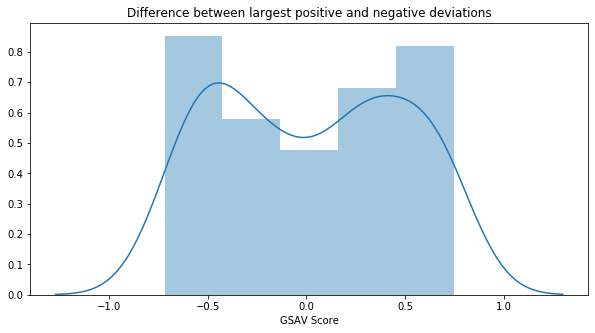

In [98]:
plt.figure(figsize=(10,5))
plt.title('Difference between largest positive and negative deviations')
sns.distplot(gsva_scores.loc['mx_diff_true'], axlabel='GSAV Score')

### GSVA Scores obtained using mx_diff=False flag

#### Calculated analogously to GSEA, gives bimodal distribution of enchrichemnt scores

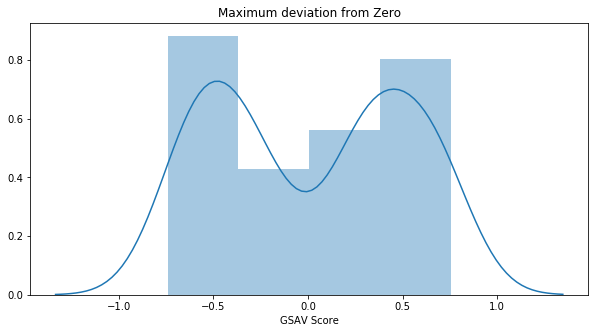

In [97]:
plt.figure(figsize=(10,5))
plt.title('Maximum deviation from Zero')
sns.distplot(gsva_scores.loc['mx_diff_false'], axlabel='GSAV Score')